
# Jupyter notebook for the case study (using Python 3)

Importing the necessary libraries: 
* Pandas package to efficiently work with DataFrames
* NumPy package for math / linear algebra
* Datetime to work with date/time data
* StandardScaler to normalize the data
* LogisticRegression - ML-model to determine key factors in Task 2
* RandomForestClassifier - ML-model for predictions in Task 3
* Train_test_split - to split data in training and test set
* cros_val_score to perform cross-validation when calibrating the model
* GridSearchCV - to perform Grid Search to find optimal hyperparameters for ML-models
* matplotlib (plt and mpath) for visualisations

In [198]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.path as mpath

## Task 1

**_1) Setup_**

defining dataset names. Can change names to add other datasets.

In [3]:
#uncomment for testing with small datasets
name_dataset_0 = 'small_app_dataset.csv' # 'app_dataset.csv'
name_dataset_1 = 'small_dataset_1.csv' # 'dataset_1.csv'
name_dataset_2 = 'small_dataset_2.csv' # 'dataset_2.csv'

In [4]:
name_dataset_0 = 'app_dataset.csv'
name_dataset_1 = 'dataset_1.csv'
name_dataset_2 = 'dataset_2.csv'

defining key names

In [5]:
key1 = 'key1'
key2 = 'key2'
key_names = [key1, key2]

saving CSV fomratted datasets as Pandas dataframes

In [6]:
dataset_0 = pd.read_csv(name_dataset_0, sep=';')
dataset_1 = pd.read_csv(name_dataset_1, sep=';')
dataset_2 = pd.read_csv(name_dataset_2, sep=';')

**_2) Investigating the datasets - checking how many rows, columns and elements they have_**

function to print the number of columns, rows and elements for each dataset

In [7]:
def print_col_row_and_cell_count(df):
    row_count, column_count = df.shape
    element_count = column_count*row_count
    print('column count:  ', column_count)
    print('row count:     ', row_count)
    print('element count: ', element_count)
    print()

total number of row and column count for each dataset (including NA values)

In [8]:
print('1) dataset 0')
print_col_row_and_cell_count(dataset_0)
print('2) dataset 1')
print_col_row_and_cell_count(dataset_1)
print('3) dataset 2')
print_col_row_and_cell_count(dataset_2)

1) dataset 0
column count:   5
row count:      798
element count:  3990

2) dataset 1
column count:   169
row count:      14571
element count:  2462499

3) dataset 2
column count:   37
row count:      10137
element count:  375069



**_3) Joining the datasets_**

In [9]:
dataset_0_and_1 = pd.merge(dataset_0, dataset_1, how='left', on=key2)

In [10]:
dataset_full_not_cleaned = pd.merge(dataset_0_and_1, dataset_2, how='left', on=key1)

In [11]:
print('dataset_full - before cleaning NAs')
print_col_row_and_cell_count(dataset_full_not_cleaned)

dataset_full - before cleaning NAs
column count:   209
row count:      798
element count:  166782



**_4) Dropping columns with keys. Removing columns and rows containing many NA values. Saving the final dateset to CSV file_**

After the join is done, keys are not needed. Dropping them.

In [12]:
dataset_full_not_cleaned_keys_dropped = dataset_full_not_cleaned.drop(key_names, axis=1)

Function to deal with NA values. It will drop rows and columns if the amount of non-NA values in a given column or row is below a given threshold. By default it is 20% for columns and 5% for rows.

In [13]:
def drop_rows_and_cols_with_NA_below_thresholds(input_df, key_names=key_names, col_thresh=0.20, row_thresh=0.05):
    df = input_df.copy(deep=True)
    
    number_of_cols = len(list(df.columns))
    row_threshold_integer = round(row_thresh * number_of_cols)
    df = df.dropna(axis=0, thresh=row_threshold_integer) # droping rows that have non-NA cell count below threshold
    
    number_of_rows = len(df)
    col_threshold_integer = round(col_thresh * number_of_rows)
    output_df = df.dropna(axis=1, thresh=col_threshold_integer).loc[:] # droping columns that have non-NA cell count below threshold
    return output_df

In [14]:
dataset_full_clean = drop_rows_and_cols_with_NA_below_thresholds(dataset_full_not_cleaned_keys_dropped, 
                                                                 col_thresh=0.20, row_thresh=0.05)

In [15]:
print('dataset_full_clean - after some columns and rows with many missing values are removed')
print_col_row_and_cell_count(dataset_full_clean)

dataset_full_clean - after some columns and rows with many missing values are removed
column count:   60
row count:      772
element count:  46320



Saving the final dataset as a CSV file

In [16]:
dataset_full_clean.to_csv('output_dataset_full_clean.csv')

**_5) Observations on data integrity _**

Overall, we see that a lot of data is not used. In the final table we have 798 rows (the same as in the 'master' dataset_0, because that dataset is used in left outer join). Dataset1 has 14571 rows, and dataset2 - 10137. Since response variable is available only for these 798 rows, we have to ignore most of the rows from dataset1 and dataset2. 

On top of that, there are a lot of missing values (NA), especially in the dataset1. The combined dataset has 209 columns, before the columns with many NAs are removed. After I remove them, applying 20% threshold, only 62 columns remain. [UPDATE - provide counts on NA in each table. Maybe update print function to show NA cells as well]

## Task 2

**_1) Setup_**

It is important to clean the dataset and to make various transformations before performing any analysis on it.

(a) Defining the name of the target variable

In [17]:
target = 'response'

(b) Defining function to get all column names except for the target and key columns. Will allow to dynamically analyze dataframes without the need to know exact columns they have

In [18]:
def get_col_names_without_target(dataframe, target = target):
    column_names_list = list(dataframe.columns)
    if target in column_names_list:
        column_names_list.remove(target)
    return column_names_list

(c) We want to determine which factors are the most important in predicting target variable (response). Many variables still has too many NAs, so I will use more agressive column threshold (60%) to remove columns/factors with many missing values. Otherwise, we would introduce too much bias if we would try to impute them all.

In [37]:
### can play with that a bit ## initially was 0.60 and 0.05
dataset_full = drop_rows_and_cols_with_NA_below_thresholds(dataset_full_clean, col_thresh=0.60, row_thresh=0.05)
print_col_row_and_cell_count(dataset_full)

column count:   38
row count:      772
element count:  29336



(d) Python uses '.' as a decimal point. However, in datasets sometimes we get ',' as a decimal point. Need to replace ',' with '.'. I will replace all '+' and '_' with ' ' and convert all string to lower case, that would help to allign string formatting and reduce some noise in the data. After this is done, will need to convert floats stored as string to Python floats. 

In [38]:
def replace_commas_with_dots_in_string(single_string):
    if type(single_string) == str:
        single_string = single_string.replace(',','.')
    return single_string

In [39]:
# applying a function on each cell of a dataframe
dataset_full = dataset_full.applymap(replace_commas_with_dots_in_string)

In [40]:
def replace_spec_chars_with_space_in_string(single_string):
    if type(single_string) == str:
        single_string = single_string.replace('+',' ')
        single_string = single_string.replace('_',' ')
    return single_string

In [41]:
dataset_full = dataset_full.applymap(replace_spec_chars_with_space_in_string)

In [42]:
def strings_to_lower_case(col):
    if col.dtype=='O':
        col = col.str.lower()
    return col        

In [43]:
dataset_full = dataset_full.apply(strings_to_lower_case)

In [44]:
#function to convert floats stored as string to floats
def convert_floats_in_string_to_floats(element):
    if type(element) == str:
        try:
            return float(element)
        except (ValueError, TypeError):
            return element
    return element

In [45]:
dataset_full = dataset_full.applymap(convert_floats_in_string_to_floats)

(e) Some columns might contain dates in string format. I will convert those to floats. It is done by firstly converting string dates to datetime format. Then from those datetimes I substract epoch date (1 jan 1970) and convert it to seconds, which is in float format. Essentially, each cell with a date after the transformation will show how many seconds has passed after 1 jan 1970 till this cell's initial date. This number is in float, so regression ML algorithms (logistic regression, random forest classifier, etc) can be applied on it.

The function below will do this transformation. It is a vectorized function, so it is efficient. Also, it will convert only those columns, that initially contain dates in string, otherwise it will not change the columns. Thus, it is very general and would work on various datasets.

In [46]:
def string_dates_to_sec_after_epoch_as_float(input_col):
    if input_col.dtype=='O': #in pandas dataframe columns containing Strings, has type Object, or 'O'
        col_datetime=pd.to_datetime(input_col, format='%Y-%m-%d %H:%M', errors='ignore') #convert to datetime only if format is '%Y-%m-%d %H:%M'
        if col_datetime.dtype=='datetime64[ns]': 
            epoch_timestamp_col = col_datetime - dt.datetime(1970, 1, 1)
            sec_float_col = epoch_timestamp_col / np.timedelta64(1, 's')
            return sec_float_col
        return col_datetime
    else:
        return input_col           

In [47]:
dataset_full_time_converted = dataset_full.apply(string_dates_to_sec_after_epoch_as_float)

(f) We have converted string columns that contain dates and floats. Now, the remaining columns with string (text) contain only categorical variables (e.g. 'big', 'small' and 'medium'). We need to convert this information to numerical data. I will do it by  creating a binary variable for each category. Binary variable (dummy) being 1 means that a given record belongs to a given category, and 0 indicates that it does not belong. If the value is missing, then a new category ('missing') is created. The initial column with strings is dropped. For example, column B contains 'yes', 'no' and 'N/A', then column B is dropped, and 3 new columns are created: B_yes, B_no and B_NA.
However, it might be not optimal to create too many binary columns for 1 column. If the number of unique categories in one string column is over a specified threshold, then I will drop it. For that, I will defina a function below.

In [48]:
def remove_string_cols_with_unique_value_count_over_threshold(input_df, unique_count_threshold = 50):
    df = input_df.copy(deep=True)
    unique_counts_in_string_cols_series = df.select_dtypes(include=[object]).nunique() #string is 'object' type
    string_cols_over_threshold_series = unique_counts_in_string_cols_series[unique_counts_in_string_cols_series>unique_count_threshold]
    list_of_string_cols_over_threshold = list(string_cols_over_threshold_series.keys())
    df = df.drop(list_of_string_cols_over_threshold, axis=1)
    return df

In [120]:
dataset_full_time_converted.shape

(772, 38)

In [124]:
dataset_full_with_some_string_cols_removed = remove_string_cols_with_unique_value_count_over_threshold(
    input_df = dataset_full_time_converted, unique_count_threshold = 50)

In [125]:
dataset_full_with_some_string_cols_removed.shape

(772, 37)

In [126]:
dataset_full_with_dummies = pd.get_dummies(dataset_full_with_some_string_cols_removed, dummy_na=True)

In [127]:
dataset_full_with_dummies.to_csv('out_dataset_full_with_dummies.csv')

(g) Imputing remaining missing values.

There are still many missing values. In order to use Machine Learning models in Task 2 and 3, I need to remove or impute missing values (NAs). In the previous parts I have removed some. The remaining will be imputed.

I am imputing missing values with a median value for each feature, as it is less biased than mean (outliers have a significant impact on mean, but not on median).

In [128]:
dataset_filled = dataset_full_with_dummies.fillna(dataset_full_with_dummies.median())

(h) Normalizing the data

In [129]:
#saving target column separately, as it should not be transformed (we need 1 and 0 for classification)
y = pd.DataFrame(dataset_filled[target].values)
predictors = get_col_names_without_target(dataset_filled)

scaler = StandardScaler() #creating an instance fo StandardScaler
scaler.fit(dataset_filled[predictors]) #normalizing only predictors
dataset_normalized_np_array = scaler.transform(dataset_filled[predictors].values) #creating numpy dataframe
dataset_normalized = pd.DataFrame(dataset_normalized_np_array, columns=predictors) #converting numpy to pandas dataframe. Adding columns
dataset_normalized[target] = y #adding target back
dataset_normalized = dataset_normalized[[target] + predictors] #for convenience putting target as a first columns

**_2) Looking at correlations_**

creating a correlation matrix between target and all features

In [130]:
corr_matrix = dataset_normalized.corr()
corr_matrix

,response,v001,v002,v4,v5,v14,v29,v120,v123,v173,...,v204_mobile,v204_residential,v204_wifi,v204_wired,v204_nan,v172.1_n,v172.1_p,v172.1_u,v172.1_y,v172.1_nan
response,1.000000,0.016594,-0.072353,-0.007668,-0.013845,-0.017492,-0.172579,0.051613,0.001951,0.042317,...,-0.024923,0.077241,-0.148913,-0.002650,0.005322,-0.045414,-0.010143,0.009589,-0.032629,0.010840
v001,0.016594,1.000000,-0.028172,0.026159,0.042749,0.026423,-0.042262,0.062640,0.065808,-0.023079,...,0.021698,0.017588,-0.037195,-0.082489,0.053279,0.018721,0.039101,-0.055188,-0.057636,0.060728
v002,-0.072353,-0.028172,1.000000,0.161154,0.089772,0.156599,0.150948,-0.019944,0.015985,0.056365,...,-0.010204,-0.090875,0.104379,0.067423,0.046851,-0.035833,-0.040280,-0.022865,0.002458,0.039053
v4,-0.007668,0.026159,0.161154,1.000000,0.738650,0.985423,0.302075,0.209135,0.277026,0.010641,...,0.016620,-0.061750,0.043348,-0.044838,0.061015,-0.023792,-0.031783,-0.048033,-0.000563,0.061561
v5,-0.013845,0.042749,0.089772,0.738650,1.000000,0.739335,0.312050,0.329635,0.383194,0.022785,...,0.017533,-0.120228,0.070998,-0.036415,0.075617,-0.008706,-0.048088,-0.061443,-0.012874,0.079078
v14,-0.017492,0.026423,0.156599,0.985423,0.739335,1.000000,0.303795,0.225246,0.289810,0.016430,...,0.019737,-0.059451,0.048794,-0.043985,0.051670,-0.023801,-0.032463,-0.039713,0.001402,0.052564
v29,-0.172579,-0.042262,0.150948,0.302075,0.312050,0.303795,1.000000,0.157450,0.163382,0.058766,...,0.033399,-0.048993,0.101896,0.056682,-0.012713,-0.013708,-0.061391,0.019671,0.023207,-0.010858
v120,0.051613,0.062640,-0.019944,0.209135,0.329635,0.225246,0.157450,1.000000,0.733878,0.017526,...,-0.030635,-0.050454,-0.033850,-0.037192,0.143450,-0.024368,-0.015127,-0.134820,0.006430,0.145945
v123,0.001951,0.065808,0.015985,0.277026,0.383194,0.289810,0.163382,0.733878,1.000000,0.051716,...,0.003460,-0.049136,0.017068,-0.029950,0.063949,-0.018716,-0.016883,-0.055532,-0.007136,0.066902
v173,0.042317,-0.023079,0.056365,0.010641,0.022785,0.016430,0.058766,0.017526,0.051716,1.000000,...,0.017673,-0.099213,0.031243,0.045614,0.059518,-0.074746,-0.059899,-0.015655,-0.058134,0.060699


getting a list (series) of correlations between the target and all features. I am interested in magnitude, so I will take absoulute values. Then I will sort them in descending order. Items in the top of the list are likely to be more important factors.

In [131]:
corr_with_target_abs_desc = corr_matrix[target].apply(np.abs).sort_values(ascending=False)
corr_with_target_abs_desc

response                                              1.000000
v192                                                  0.194025
v191                                                  0.194025
v29                                                   0.172579
v204_wifi                                             0.148913
v204_business                                         0.105443
v204_cellular                                         0.097367
v204_residential                                      0.077241
v002                                                  0.072353
v182                                                  0.066963
v120                                                  0.051613
v177                                                  0.048428
v172.1_n                                              0.045414
v174                                                  0.044762
v173                                                  0.042317
v195_low                                              0

It can be seen that many features have the same correlation with the target (e.g. v191 and v192). Thus, I can exclude some redundant features (e.g. dimensionality reduction). 
Below I define a function that will exclude redundant features and return a list of 'unique' features.

In [132]:
def exclude_similar_features_and_get_unique(corr_with_target_series, similarity_param = 0.000001):
    exclusion_boolean_list = [True] # first item not to be excluded
    for i in range(1, len(corr_with_target_series)):
        if np.isnan(corr_with_target_series[i]):
            exclusion_boolean_list.append(False)
        elif (corr_with_target_series[i-1] - corr_with_target_series[i])<=similarity_param:
            exclusion_boolean_list.append(False)
        else:
            exclusion_boolean_list.append(True)
    unique_features = list(corr_with_target_series[exclusion_boolean_list].index)
    return unique_features

In [133]:
unique_features = exclude_similar_features_and_get_unique(corr_with_target_abs_desc)

In [134]:
unique_features

['response',
 'v192',
 'v29',
 'v204_wifi',
 'v204_business',
 'v204_cellular',
 'v204_residential',
 'v002',
 'v182',
 'v120',
 'v177',
 'v172.1_n',
 'v174',
 'v173',
 'v195_low',
 'v172.1_y',
 'v201_moderate risk',
 'v181',
 'v204_mobile',
 'v178_certified',
 'v180',
 'v193_yes',
 'v178_validdomain',
 'v183',
 'v184_lower fraud risk',
 'v176',
 'v186_fraud score 101 to 300',
 'v178_verified',
 'v195_moderate',
 'v185',
 'v14',
 'v204_dialup',
 'v001',
 'v175',
 'v5',
 'v184_data entry review',
 'v203_nan',
 'v172.1_p',
 'v172.1_u',
 'v4',
 'v186_fraud score 1 to 100',
 'v201_moderate by proxy reputation and country code',
 'v204_nan',
 'v204_wired',
 'v184_moderate fraud risk',
 'v123']

I will create a new dataset that will contain only the target and 'unique' features.

_Note: in fact I have tried to run the logistic regression both with redundant features and without. The results are the same. So it is mainly about computational efficiency._

In [135]:
dataset_normalized_unique_features=dataset_normalized[unique_features] # - use this to keep only unique features


**_3) Trying the model with basic settings_**

To determine the strongest predictors logistic regression is a good ML-algorithm. I choose Regression, because it will expclicitly show which factors have more impact on the target and which less. I will use L2 and L1 regularization that allows to deal with collinearity and overfitting. 

(b) I will split the data to the train and test sets. Training set will be used to train and calibrate the model. Test set is used to assess the final model. Test set is 20% of the data and train set - 80%. Random state is set to 1, so that the data is split in the same manner every time I run the split function.

In [136]:
train, test = train_test_split(dataset_normalized_unique_features, test_size=0.2, random_state=1)

(c) Creating a model. C (L2 regularization parameter) is set to 1, but will be calibrated later. I will fit intercept to have less biased coefficient. 

In [137]:
log_reg = LogisticRegression(penalty='l2', C=1, fit_intercept=True, random_state=1)

(d) getting predictor names 

In [138]:
#get columns names except the target
predictors = get_col_names_without_target(dataset_normalized_unique_features, target='response')

In [139]:
###
len(predictors)

45

(e) I use cross validation to see what is the accuracy of the model with basic settings

In [140]:
# here I define a function to conveniently do cross-validation and print the results
def print_scores(model, X_features, Y_target):
    scores = cross_val_score(model, X_features, Y_target, cv=5)
    print('accuracies =', scores)
    print('mean accuracy =', scores.mean())    

In [141]:
print_scores(log_reg, train[predictors], train[target])

accuracies = [ 0.80645161  0.83870968  0.76612903  0.80487805  0.83606557]
mean accuracy = 0.810446789026


(f) It is good to compare performance of my model with majority class prediction model. This is the minimum accuracy that my model should achive. Majority class naive prediction is when you predict that every record belongs to a majority class. In this case it would give the following accuracy:

In [142]:
(1-train[target].mean())

0.807131280388979

In [143]:
(1-test[target].mean())

0.8516129032258064

My model gives essentially the same results, so it is not a very bad model, but  also not a good one. Thus, need to calibrate it further.

**_3) Calibrating the model_**

(a) we have an inbalanced dataset - 80.7% of data has response value of 0 and 19.3% - 1. I will try to use 'balanced' class_weight to tackle that. 

In [144]:
log_reg_balanced = LogisticRegression(penalty='l2', C=1, fit_intercept=True, random_state=1, class_weight='balanced')

In [145]:
print_scores(log_reg_balanced, train[predictors], train[target])

accuracies = [ 0.62903226  0.62096774  0.62903226  0.64227642  0.62295082]
mean accuracy = 0.6288519001


This model is actually much worse, so no need to use class_weight functionality.

(b) trying Logistic Regression with L1 regularization

In [146]:
log_reg_l1 = LogisticRegression(penalty='l1', C=1, fit_intercept=True, random_state=1)

In [147]:
print_scores(log_reg_l1, train[predictors], train[target])

accuracies = [ 0.78225806  0.83870968  0.78225806  0.80487805  0.8442623 ]
mean accuracy = 0.810473230063


Log.reg. model with L1 regularization give better rezults than the majority class prediction model. It also outperforms log.reg. with L2  regularization. So, I will stick to that model.

(c) Calibration regularization parameter C. Firstly, I try a wide band of values.

In [148]:
for C_param in [0.01, 0.1, 0.5, 1, 2, 5, 15, 100]:
    log_reg_l1_diff_c = LogisticRegression(penalty='l1', C=C_param, fit_intercept=True, random_state=1)
    print('c param =', C_param)
    print_scores(log_reg_l1_diff_c, train[predictors], train[target])
    print()

c param = 0.01
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

c param = 0.1
accuracies = [ 0.80645161  0.81451613  0.80645161  0.81300813  0.83606557]
mean accuracy = 0.815298611738

c param = 0.5
accuracies = [ 0.79032258  0.83870968  0.78225806  0.78861789  0.8442623 ]
mean accuracy = 0.808834100768

c param = 1
accuracies = [ 0.78225806  0.83870968  0.78225806  0.80487805  0.8442623 ]
mean accuracy = 0.810473230063

c param = 2
accuracies = [ 0.79032258  0.83870968  0.78225806  0.80487805  0.83606557]
mean accuracy = 0.810446789026

c param = 5
accuracies = [ 0.7983871   0.83870968  0.77419355  0.79674797  0.83606557]
mean accuracy = 0.808820772766

c param = 15
accuracies = [ 0.81451613  0.83870968  0.76612903  0.79674797  0.83606557]
mean accuracy = 0.810433675992

c param = 100
accuracies = [ 0.81451613  0.83870968  0.76612903  0.78861789  0.81967213]
mean accuracy = 0.805528971207



The optimal C parameter is somewhere between 0.1 - 1, so I will narrow down the search in this interval.

In [150]:
for C_param in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]:
    log_reg_l1_diff_c = LogisticRegression(penalty='l1', C=C_param, fit_intercept=True, random_state=1)
    print('c param =', C_param)
    print_scores(log_reg_l1_diff_c, train[predictors], train[target])
    print()

c param = 0.05
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

c param = 0.1
accuracies = [ 0.80645161  0.81451613  0.80645161  0.81300813  0.83606557]
mean accuracy = 0.815298611738

c param = 0.2
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819

c param = 0.3
accuracies = [ 0.7983871   0.83870968  0.79032258  0.79674797  0.8442623 ]
mean accuracy = 0.81368592348

c param = 0.4
accuracies = [ 0.7983871   0.83870968  0.78225806  0.78861789  0.8442623 ]
mean accuracy = 0.810447003994

c param = 0.5
accuracies = [ 0.79032258  0.83870968  0.78225806  0.78861789  0.8442623 ]
mean accuracy = 0.808834100768

c param = 0.6
accuracies = [ 0.7983871   0.83870968  0.78225806  0.78861789  0.8442623 ]
mean accuracy = 0.810447003994

c param = 0.7
accuracies = [ 0.79032258  0.83870968  0.78225806  0.78861789  0.8442623 ]
mean accuracy = 0.808834100768

c param = 0.8
accuracies = [ 0.78

The optimal value is 0.2. I will use that.

d) Will look for optimal Tolerance for stopping criteria (tol).

In [153]:
for tol in [1e-8, 1e-6, 1e-4, 1e-2, 1e-1]:
    log_reg_l1_diff_tol = LogisticRegression(penalty='l1', C=0.2, tol = tol, fit_intercept=True, random_state=1)
    print('tol param =', tol)
    print_scores(log_reg_l1_diff_tol, train[predictors], train[target])
    print()

tol param = 1e-08
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819

tol param = 1e-06
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819

tol param = 0.0001
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819

tol param = 0.01
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819

tol param = 0.1
accuracies = [ 0.80645161  0.83870968  0.7983871   0.81300813  0.83606557]
mean accuracy = 0.81852441819



All give the same results, so I will stick to the default value of 1e-4

e) I will perform cross-validation of the model with optimal parameters on the training set. Then, will check it's performance on the whole train set and the check it on the test set.

In [154]:
# cross validation on train set
log_reg_final = LogisticRegression(penalty='l1', C=0.1, fit_intercept=True, random_state=1)
print_scores(log_reg_final, train[predictors], train[target])

accuracies = [ 0.80645161  0.81451613  0.80645161  0.81300813  0.83606557]
mean accuracy = 0.815298611738


In [155]:
# train the model on train-set and evaluate on train set
log_reg_final.fit(train[predictors], train[target])
log_reg_final.score(train[predictors], train[target])

0.8233387358184765

In [156]:
# check model on the test set
log_reg_final.score(test[predictors], test[target])

0.85161290322580641

Accuracy is consistent (from 0.80 to 0.85). Model is not overfitting, since the score on the whole train set is 0.82 which is consistent with other scores.

**_4) Determening the key factors with the final model_**

a) Will train the model on the whole dataset and check the score.

In [157]:
full_set = dataset_normalized_unique_features
log_reg_final.score(full_set[predictors], full_set[target])

0.82901554404145072

b) getting the coefficients on the features

In [158]:
coef_array = log_reg_final.coef_

In [159]:
coef_series = pd.Series(coef_array[0], predictors)

Similarly as with correlation coefficients, I will get the absolute values and sort them.

In [160]:
sorted_coefficients = coef_series.apply(np.abs).sort_values(ascending=False)

c) findings

Below is the list of factors from the most important factor (v29) to the least important factors (v184_Lower Fraud Risk and all below it).

In [161]:
sorted_coefficients

v29                                                   0.355103
v204_wifi                                             0.312712
v192                                                  0.270813
v204_business                                         0.175122
v195_low                                              0.085339
v182                                                  0.083630
v120                                                  0.068040
v002                                                  0.051416
v204_residential                                      0.047279
v204_cellular                                         0.044461
v5                                                    0.028367
v177                                                  0.004279
v178_validdomain                                      0.000000
v172.1_n                                              0.000000
v174                                                  0.000000
v173                                                  0

In [325]:
top15_coef = sorted_coefficients[:20]
top15_coef

v29                   0.355103
v204_wifi             0.312712
v192                  0.270813
v204_business         0.175122
v195_low              0.085339
v182                  0.083630
v120                  0.068040
v002                  0.051416
v204_residential      0.047279
v204_cellular         0.044461
v5                    0.028367
v177                  0.004279
v178_validdomain      0.000000
v172.1_n              0.000000
v174                  0.000000
v173                  0.000000
v172.1_y              0.000000
v201_moderate risk    0.000000
v181                  0.000000
v204_mobile           0.000000
dtype: float64

In [222]:
top15_coef.keys()

Index(['v29', 'v204_wifi', 'v192', 'v204_business', 'v195_low', 'v182', 'v120',
       'v002', 'v204_residential', 'v204_cellular', 'v5', 'v177',
       'v178_validdomain', 'v172.1_n', 'v174'],
      dtype='object')

In [221]:
top15_coef.values

array([ 0.3551034 ,  0.31271249,  0.27081309,  0.17512241,  0.0853392 ,
        0.08363011,  0.06804037,  0.05141584,  0.04727882,  0.04446084,
        0.02836743,  0.00427913,  0.        ,  0.        ,  0.        ])

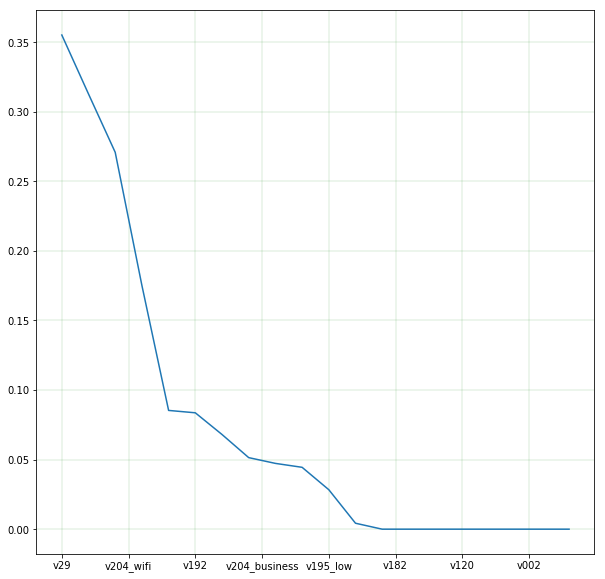

In [329]:
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)



fig, ax = plt.subplots(1,1, figsize=(10,10))

x = list(top15_coef.keys()) 
y = list(top15_coef.values) 

ax.plot(np.arange(0, len(x), 1), y) #, '--r', marker=cut_star, markersize=15)
ax.set_xticklabels(['empty']+x)
ax.grid(color='g', linestyle='-', linewidth=0.15)

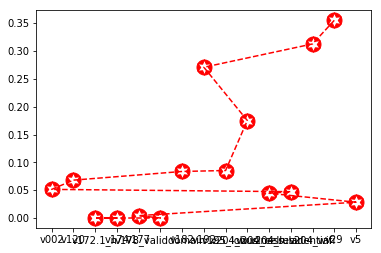

In [223]:
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)


plt.plot(list(top15_coef.keys()), top15_coef.values,  '--r', marker=cut_star, markersize=15)

plt.show()

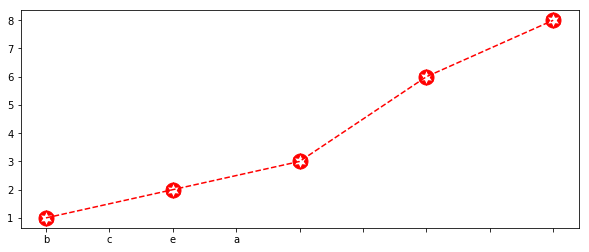

In [270]:
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig, ax = plt.subplots(1,1, figsize=(10,4))
x = ['f', 'b', 'c', 'e', 'a']
y = [1, 2, 3, 6, 8]

ax.set_xticklabels(['f', 'b', 'c', 'e', 'a'])
ax.plot(np.arange(5), y, '--r', marker=cut_star, markersize=15)

#fig.show()

#plt.plot(x, y, '--r', marker=cut_star, markersize=15)
#plt.axis.set_xticklabels(['f', 'b', 'c', 'e', 'a'])

#plt.show()

AttributeError: 'function' object has no attribute 'set_xticklabels'

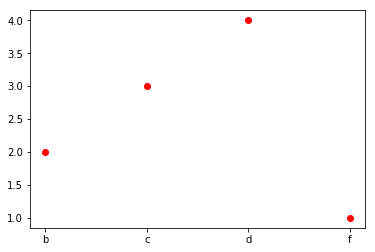

In [288]:
plt.plot(['f', 'b', 'c', 'd'], [1,2,3,4], 'ro')
#plt.axis([0, 6, 0, 10])
plt.axis.set_xticklabels(['zero', 'f', 'b', 'c', 'e', 'a'])
plt.show()

[Text(0,0,'empty'),
 Text(0,0,'x'),
 Text(0,0,'b'),
 Text(0,0,'c'),
 Text(0,0,'d'),
 Text(0,0,'e'),
 Text(0,0,'f')]

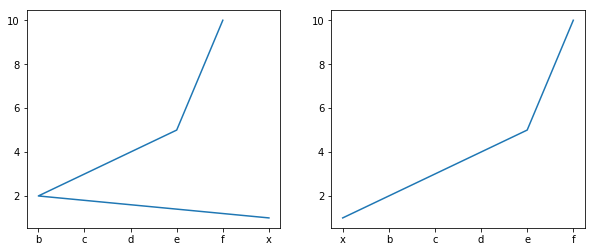

In [299]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

x = ['x','b','c','d','e','f'] #[2,4,3,6,1,7]
y = [1,2,3,4,5,10]

ax[0].plot(x, y)

ax[1].plot(np.arange(1, len(x)+1), y)
ax[1].set_xticklabels(['empty']+x)

The most important predictors are v29, v192, v204\*, v195_Low\**, v182, v120, v002, v5. 

These findings are consistent with the correlation table obtained earlier. The former showed consistent results, where v192, v29, v204, v182, and v120 are top factors as well.

Because of similarity/redundancy I have excluded some factors earlier. Most importantly, I have excluded v191 (which is identical to v192). But, I could say that v191 is also an important regressor. 


\* from which I created several dummies. Important ones are - v204_wifi, v204_business, v204_residential, v204_cellular; and not important - v204_mobile, v204_nan, v204_wired. But overall I can conclude that this feature is important.

\** Below I will do some F-tests, to check if some of the factors are important statistically. It is not really part of ML-approach, it is more out of curiosity.

d) extra section - performing F tests on various predictors to assess their statistical significance.

In [162]:
from sklearn.feature_selection import f_regression

f_regression is used to performa F tests. For the chosen predictors or groups of predictors I will show p-values of F-scores.

In [163]:
f_regression(full_set[['v195_low','v195_moderate']],full_set[target])[1]

array([ 0.3409731,  0.5936604])

v195 - does not appear to be a statistically significatn factor.

In [164]:
f_regression(full_set[['v29']],full_set[target])[1]

array([  1.41016123e-06])

In [165]:
f_regression(full_set[['v192']],full_set[target])[1]

array([  5.51245921e-08])

v29 and v129 - do appear to be a statistically significant factors.

## Task 3

I will use RandomForestClassifier model to do the predictions. It is a very powerful model both theoretically and empirically. It works well against ovefitting. At the same time, it has only few parameters that are not too sensitive too changes. So, it is relatively easy to calibrate them.

I will use the same train and test set from Task 2. It will save space and it will allow to compare Random Forest model with Logistic regression.

__ 1) Random_Forest with default parameters. __

(a) creating a model with default parameters. Exception - random_state=1 to get the same results for different runs. n_jobs=-1 - utilizing all the cores, it will increase speed, but does not affect accuracy.

In [166]:
Random_Forest_model = RandomForestClassifier(n_jobs=-1, random_state=1)

(b) cross-validation with basic setings.

In [167]:
print_scores(Random_Forest_model, train[predictors], train[target])

accuracies = [ 0.75806452  0.78225806  0.80645161  0.81300813  0.80327869]
mean accuracy = 0.792612202431


Results are not better than simply predicting the majority class. Also, the optimized logistic regression was giving better results.

__ 2) Calibrating the model - Part A, looking at paremeters separately__

(a) Firstly will try with the number of trees to be built (n_estimators).

In [168]:
for n_estimators in [1, 5, 10, 30, 50, 70, 100, 120, 150, 200, 300, 500]:
    Random_Forest_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=1)
    print('n_estimators =', n_estimators)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

n_estimators = 1
accuracies = [ 0.66129032  0.71774194  0.71774194  0.77235772  0.71311475]
mean accuracy = 0.716449334245

n_estimators = 5
accuracies = [ 0.75806452  0.75806452  0.76612903  0.80487805  0.81147541]
mean accuracy = 0.779722304627

n_estimators = 10
accuracies = [ 0.75806452  0.78225806  0.80645161  0.81300813  0.80327869]
mean accuracy = 0.792612202431

n_estimators = 30
accuracies = [ 0.79032258  0.82258065  0.79032258  0.82926829  0.81147541]
mean accuracy = 0.808793901794

n_estimators = 50
accuracies = [ 0.79032258  0.81451613  0.80645161  0.82113821  0.83606557]
mean accuracy = 0.813698821547

n_estimators = 70
accuracies = [ 0.7983871   0.80645161  0.81451613  0.82113821  0.83606557]
mean accuracy = 0.815311724772

n_estimators = 100
accuracies = [ 0.79032258  0.81451613  0.82258065  0.80487805  0.81967213]
mean accuracy = 0.810393906953

n_estimators = 120
accuracies = [ 0.79032258  0.81451613  0.7983871   0.80487805  0.82786885]
mean accuracy = 0.807194541538



50, 70 and 100 seems to be the best. Will stick to 50 for time-being. With less trees to built, the model will work faster.

(b) Optimize the min number of observations needed to do the split (min_samples_split).

In [169]:
for min_samples_split in [2, 3, 5, 7, 10, 12, 15, 20, 30, 50, 70, 100, 150, 250, 500]:
    Random_Forest_model = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=50, n_jobs=-1, random_state=1)
    print('min_samples_split =', min_samples_split)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

min_samples_split = 2
accuracies = [ 0.79032258  0.81451613  0.80645161  0.82113821  0.83606557]
mean accuracy = 0.813698821547

min_samples_split = 3
accuracies = [ 0.80645161  0.81451613  0.81451613  0.81300813  0.81147541]
mean accuracy = 0.811993482177

min_samples_split = 5
accuracies = [ 0.78225806  0.81451613  0.81451613  0.82926829  0.82786885]
mean accuracy = 0.813685493545

min_samples_split = 7
accuracies = [ 0.79032258  0.81451613  0.81451613  0.82113821  0.81967213]
mean accuracy = 0.812033036248

min_samples_split = 10
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

min_samples_split = 12
accuracies = [ 0.78225806  0.80645161  0.80645161  0.81300813  0.81967213]
mean accuracy = 0.80556831031

min_samples_split = 15
accuracies = [ 0.80645161  0.80645161  0.81451613  0.81300813  0.82786885]
mean accuracy = 0.813659267476

min_samples_split = 20
accuracies = [ 0.7983871   0.80645161  0.80645161  0.82113821  0.8114754

10 seems to be optimal, will stick to that for some time. Later will need to do a grid search with several parameters at the same time.

(c) Optimize class_weight parameters - whether to adjust weights due to class disbalance or no.

In [170]:
for class_weight in [None, 'balanced']:
    Random_Forest_model = RandomForestClassifier(class_weight=class_weight, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('class_weight =', class_weight)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

class_weight = None
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

class_weight = balanced
accuracies = [ 0.75806452  0.81451613  0.76612903  0.7804878   0.81967213]
mean accuracy = 0.787773922689



None is better, thus will stick to default class_weight=None.

(d) Whether bootstrap samples are used when building trees or no.

In [171]:
for bootstrap in [True, False]:
    Random_Forest_model = RandomForestClassifier(bootstrap=bootstrap, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('bootstrap =', bootstrap)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

bootstrap = True
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

bootstrap = False
accuracies = [ 0.7983871   0.80645161  0.7983871   0.82926829  0.80327869]
mean accuracy = 0.807154557532



Will use the default, bootstrap=True, it is a bit better

(e) Whether to use out-of-bag samples to estimate the generalization accuracy.

In [172]:
for oob_score in [True, False]:
    Random_Forest_model = RandomForestClassifier(oob_score=oob_score, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('oob_score =', oob_score)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

oob_score = True
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

oob_score = False
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452



No difference. Will use the default, oob_score=False.

(f) criterion - the function to measure the quality of a split. 

In [173]:
for criterion in ['entropy', 'gini']:
    Random_Forest_model = RandomForestClassifier(criterion=criterion, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('criterion =', criterion)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

criterion = entropy
accuracies = [ 0.7983871   0.80645161  0.82258065  0.82113821  0.82786885]
mean accuracy = 0.815285283736

criterion = gini
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452



The default's 'gini' is better. 

(g) max_features - the number of features to consider when looking for the best split

In [174]:
for max_features in ['auto', 'sqrt', 'log2', None, 0.1, 0.25, 0.5, 0.75, 1.0]:
    Random_Forest_model = RandomForestClassifier(max_features=max_features, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('max_features =', max_features)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

max_features = auto
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

max_features = sqrt
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

max_features = log2
accuracies = [ 0.79032258  0.81451613  0.80645161  0.82926829  0.83606557]
mean accuracy = 0.815324837807

max_features = None
accuracies = [ 0.78225806  0.83870968  0.7983871   0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_features = 0.1
accuracies = [ 0.7983871   0.80645161  0.83064516  0.82113821  0.82786885]
mean accuracy = 0.816898186962

max_features = 0.25
accuracies = [ 0.79032258  0.81451613  0.79032258  0.82113821  0.81967213]
mean accuracy = 0.80719432657

max_features = 0.5
accuracies = [ 0.78225806  0.81451613  0.79032258  0.80487805  0.82786885]
mean accuracy = 0.803968735087

max_features = 0.75
accuracies = [ 0.76612903  0.81451613  0.7983871   0.81300813  0.81147541]
mean accuracy = 0.8

The default's 'auto' is the best. But will try with the number of features as integer.

In [176]:
for max_features in [1, 2, 3, 5, 10, 20, 30, 40]:
    Random_Forest_model = RandomForestClassifier(max_features=max_features, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('max_features =', max_features)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

max_features = 1
accuracies = [ 0.79032258  0.82258065  0.82258065  0.81300813  0.82786885]
mean accuracy = 0.815272170702

max_features = 2
accuracies = [ 0.80645161  0.81451613  0.82258065  0.81300813  0.81147541]
mean accuracy = 0.813606385403

max_features = 3
accuracies = [ 0.7983871   0.82258065  0.83870968  0.81300813  0.81967213]
mean accuracy = 0.818471536117

max_features = 5
accuracies = [ 0.79032258  0.81451613  0.80645161  0.82926829  0.83606557]
mean accuracy = 0.815324837807

max_features = 10
accuracies = [ 0.7983871   0.80645161  0.79032258  0.79674797  0.81147541]
mean accuracy = 0.800676933528

max_features = 20
accuracies = [ 0.7983871   0.80645161  0.80645161  0.81300813  0.82786885]
mean accuracy = 0.810433461024

max_features = 30
accuracies = [ 0.78225806  0.82258065  0.78225806  0.82113821  0.81147541]
mean accuracy = 0.803942079082

max_features = 40
accuracies = [ 0.77419355  0.83064516  0.7983871   0.82113821  0.81147541]
mean accuracy = 0.807167885534



'auto' is still better

(h) The maximum depth of the tree.  

In [177]:
for max_depth in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
    Random_Forest_model = RandomForestClassifier(max_depth=max_depth, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('max_depth  =', max_depth )
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

max_depth  = 1
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_depth  = 3
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_depth  = 5
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_depth  = 10
accuracies = [ 0.79032258  0.80645161  0.80645161  0.81300813  0.81967213]
mean accuracy = 0.807181213536

max_depth  = 15
accuracies = [ 0.81451613  0.80645161  0.81451613  0.82113821  0.83606557]
mean accuracy = 0.818537531224

max_depth  = 20
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.83606557]
mean accuracy = 0.81852441819

max_depth  = 30
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

max_depth  = 50
accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452

max_depth  = 100
acc

30 seems optimal. Will choose it for now.

(j) max_leaf_nodes  - the max number of leaf nodes. 

In [178]:
for max_leaf_nodes in [2, 5, 10, 20, 50, 100, 200, 500, 600, None]:
    Random_Forest_model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, max_depth=30, min_samples_split=10, 
                                                 n_estimators=50, n_jobs=-1, random_state=1)
    print('max_leaf_nodes =', max_leaf_nodes)
    print_scores(Random_Forest_model, train[predictors], train[target])
    print()

max_leaf_nodes = 2
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_leaf_nodes = 5
accuracies = [ 0.80645161  0.80645161  0.80645161  0.80487805  0.81147541]
mean accuracy = 0.807141659465

max_leaf_nodes = 10
accuracies = [ 0.80645161  0.80645161  0.81451613  0.80487805  0.81147541]
mean accuracy = 0.808754562691

max_leaf_nodes = 20
accuracies = [ 0.7983871   0.80645161  0.83064516  0.81300813  0.81967213]
mean accuracy = 0.813632826439

max_leaf_nodes = 50
accuracies = [ 0.7983871   0.80645161  0.82258065  0.82113821  0.81967213]
mean accuracy = 0.813645939474

max_leaf_nodes = 100
accuracies = [ 0.7983871   0.80645161  0.82258065  0.82113821  0.81967213]
mean accuracy = 0.813645939474

max_leaf_nodes = 200
accuracies = [ 0.7983871   0.80645161  0.82258065  0.82113821  0.81967213]
mean accuracy = 0.813645939474

max_leaf_nodes = 500
accuracies = [ 0.7983871   0.80645161  0.82258065  0.82113821  0.81967213]
mean accuracy =

The default's None is better. 

__ 2) Calibrating the model - Part B, optimizing some parameters together with grid search__

Many parameters are interelated. In RandomForest models parameters like max_depth, min_leafs_at_split, number of trees are all aimed at reducing overfitting in one way or anothers. Thus, it is very useful to try them simultaniously. Of course, it is very computationally expensive to estimate all of them together and to try many values. Thus, I will use only some of those I have obtained in Part A.

Firstly I define parameter grid

In [181]:
param_grid_1 = {
    'min_samples_split':[2,5,10,20],
    'max_features':['auto',1,2,'log2'],
    'max_depth':[5, 20, 30, 100, None]
}

Define grid search

In [184]:
grid_search_1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 50,                                                                
                                                              max_depth=30,
                                                              random_state=1, n_jobs=-1), 
         param_grid = param_grid_1, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

Perform the search

In [186]:
grid_search_1.fit(train[predictors],train[target])
grid_search_1.grid_scores_, grid_search_1.best_params_, grid_search_1.best_score_

C:\Users\ilja.surikovs\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81038, std: 0.00335, params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2},
  mean: 0.81038, std: 0.00335, params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 5},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 10},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 20},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 1, 'min_samples_split': 2},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 1, 'min_samples_split': 5},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 1, 'min_samples_split': 10},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 1, 'min_samples_split': 20},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 2, 'min_samples_split': 2},
  mean: 0.80714, std: 0.00225, params: {'max_depth': 5, 'max_features': 2, '

Will narrow down the grid search a bit. For max_features will use 'auto'. Will add number of trees (n_estimators).

In [187]:
param_grid_2 = {
    'min_samples_split':[6,8,10,12],    
    'max_depth':[26, 28, 30, 32, 34, None],
    'n_estimators':[10, 50, 100, 300]
}

In [188]:
grid_search_2 = GridSearchCV(estimator = RandomForestClassifier(random_state=1, n_jobs=-1), 
         param_grid = param_grid_2, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

In [189]:
grid_search_2.fit(train[predictors],train[target])
grid_search_2.grid_scores_, grid_search_2.best_params_, grid_search_2.best_score_

C:\Users\ilja.surikovs\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81683, std: 0.02546, params: {'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 10},
  mean: 0.80877, std: 0.01065, params: {'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 50},
  mean: 0.81691, std: 0.01235, params: {'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 100},
  mean: 0.81366, std: 0.01065, params: {'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 300},
  mean: 0.79748, std: 0.01765, params: {'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 10},
  mean: 0.80718, std: 0.01316, params: {'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 50},
  mean: 0.81529, std: 0.00979, params: {'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 100},
  mean: 0.81690, std: 0.01019, params: {'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 300},
  mean: 0.80397, std: 0.01281, params: {'max_depth': 26, 'min_samples_split': 10, 'n_estimators': 10},
  mean: 0.82016, std: 0.01206, params: {'max_depth': 26, 'min_samples_split':

Will test for various numbers of trees.

In [191]:
param_grid_3 = {
    'n_estimators':[40, 45, 50, 55, 60, 100]
}

In [192]:
grid_search_3 = GridSearchCV(estimator = RandomForestClassifier(max_depth=26,
                                                                min_samples_split=10,
                                                                random_state=1, n_jobs=-1), 
         param_grid = param_grid_3, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

In [193]:
grid_search_3.fit(train[predictors],train[target])
grid_search_3.grid_scores_, grid_search_3.best_params_, grid_search_3.best_score_

C:\Users\ilja.surikovs\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81039, std: 0.00922, params: {'n_estimators': 40},
  mean: 0.81691, std: 0.01003, params: {'n_estimators': 45},
  mean: 0.82016, std: 0.01206, params: {'n_estimators': 50},
  mean: 0.82016, std: 0.01206, params: {'n_estimators': 55},
  mean: 0.82016, std: 0.01206, params: {'n_estimators': 60},
  mean: 0.81366, std: 0.00935, params: {'n_estimators': 100}],
 {'n_estimators': 50},
 0.8201637624520085)

The optimized model has the following parameters: max_depth=26, min_samples_split=10, n_estimators=50. The other parameters has their default values.

__3) Let's check the model (a) with cross-validation on the train set, (b) then simply on the whole train set, (c) then on test set.__

In [194]:
Random_Forest_model = RandomForestClassifier(max_depth=26, min_samples_split=10, 
                                             n_estimators=50, n_jobs=-1, random_state=1)
print_scores(Random_Forest_model, train[predictors], train[target])

accuracies = [ 0.81451613  0.81451613  0.81451613  0.81300813  0.8442623 ]
mean accuracy = 0.820163762452


In [195]:
# train the model on train-set and evaluate on train set
Random_Forest_model.fit(train[predictors], train[target])
Random_Forest_model.score(train[predictors], train[target])

0.89951377633711505

Here we see that the model is overfitting. Thus, it is likely that it could be further optimized. In theory I should reach the point where the score on train set (where target is known) and on test set (where target is not known) are the same

In [196]:
# check model on the test set
Random_Forest_model.score(test[predictors], test[target])

0.85161290322580641

Thus, this model gives a higher accuracy than a majority class prediction model would give. Also, it gives a higher accuracy than the logistic regression in the previous task. However, I do not see a significant improvement, thus a higher focus should be put on feature selection and dealing with missing values. Also, it would be interesting to try some other models like XGboost or some SVM.
It is a bit dissapointing the the model does not perform much better than majority class prediction. However, if we would focus not just on accuracy, but on other aspects like precision and recall, than perhaps it would be more useful.

## Task 4

1) Deal with imbalaced dataset. Out of 798 observations, response variable is 0 in 645 observations, and it is 1 in 153 cases. It is not a very big disbalance, but it is possible that prediction accuracy would be better if I would deal with this imbalancing. (a) The simplest approach is to randomly remove 492 rows where response variable is 0, this would result in a balaced dataset where we have 153 cases of response variable being 0 and 153 casee being 1. (b) A bit better approach would be to put more weight on obseravations where response is 1. Each such observation would weigh 4.2 (645/153). (c) Employ some of the many other approaches of dealing with imbalanced dataset.

2) Columns v173, v175 and v177 contain some date information. It would be good to understand what these dates are about and then to extract some valuable features. It could be: duration, starting and end time in hours, days, months, etc. Such information could be helpful at making better predictions.


3) I am mainly removing columns with many NAs. For rows I was more conservative - I was removing only those that had all NA values except for key columns. It might be beneficial to apply a threshold and remove rows that has too many missing values (similarly as I did with columns).

4) Use better techniques for dimensionality reduction

5) Use SVM for sparse datasets

6) Drop columns that has too few variations.

In [ ]:
##############################################################################################################################

In [ ]:
type(corr_with_target_abs_desc)

In [ ]:
corr_with_target_abs_desc.shape

In [ ]:
tmp_list = ['a','b','c']
for i, item in enumerate(tmp_list,1):
    print('i=',i)
    print('item=',item)

print()
for j in range(1, len(tmp_list)):
    print(tmp_list[j])

In [ ]:
corr_with_target_abs_desc[[True, True, True] + [False]*74]

In [ ]:
corr_with_target_abs_desc[my_bool_list]

In [ ]:
corr_with_target_abs_desc[my_bool_list].shape

In [ ]:
corr_with_target_abs_desc.shape

In [ ]:
corr_with_target_abs_desc

In [ ]:
log_reg.fit(train[predictors], train[target])

In [ ]:
log_reg.score(train[predictors], train[target])

In [ ]:
log_reg.score(test[predictors], test[target])

In [ ]:
log_reg.get_params()

In [ ]:
log_reg.coef_

In [ ]:
coef_df = pd.DataFrame(log_reg.coef_, columns=predictors)
coef_df

In [ ]:
max(coef_df)

In [ ]:
log_reg.intercept_

In [ ]:
dataset_normalized.corr()['response'].apply(np.abs).sort_values(ascending=False)

In [ ]:
plt_plot = plt.matshow(dataset_filled.corr())

In [ ]:
plt_fig = plt_plot.get_figure()
plt_fig.savefig('fig_plt.png')

In [ ]:
plt.savefig('graph_1.png', bbox_inches='tight')

In [ ]:
%matplotlib notebook

In [ ]:
%pylab qt

In [251]:
%matplotlib inline

In [ ]:
%matplotlib qt

In [ ]:
plt.matshow(dataset_filled.corr())

In [ ]:
dataset_filled.corr()

In [ ]:
import seaborn as sns
corr = dataset_filled.corr()
myplot_seaborn=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
myfig_seaborn = myplot_seaborn.get_figure()
myfig_seaborn.savefig('fig_seaborn.png')

In [ ]:
take only text columns 

In [ ]:
replace ',' with '.' in floats => use regex (*[N*int','M*int])

impute missing values!!!

normalize all data

one hot encoder / create dummies for text information

train regularized regression 

dimensionality reduction

In [ ]:
len(dataset_full_with_dummies.median())

In [ ]:
def get_col_names_without_target(dataframe, target = target):
    column_names_list = list(dataframe.columns)
    if target in column_names_list:
        column_names_list.remove(target)
    return column_names_list

In [ ]:
def get_col_names_without_target(dataframe, target = target):
    all_column_names_list = list(dataframe.columns)
    col_names_without_target = all_column_names_list.remove[target]
    return list(col_names_without_target)

In [ ]:
mylist = ['a', 'b', 'c']
mylist

In [ ]:
mylist.remove('a')
mylist

In [ ]:
'a' in mylist

In [ ]:
dataset_orange.domain

In [ ]:
dataset_orange.save("output_dataset_orange.csv")

In [ ]:
dataset_normalized

In [ ]:
dataset_normalized.to_csv("output_dataset_normalized.csv")

In [ ]:
dataset_full_not_cleaned_keys_dropped.to_csv('output_dataset_full_not_cleaned_keys_dropped.csv')

In [ ]:
set(dataset_full_with_dummies.dtypes)

In [ ]:
dataset_full_with_dummies_np[1]

In [ ]:
dataset_full_np2

In [ ]:
len(dataset_full_np2)

In [ ]:
dataset_full_np2.shape

In [ ]:
dataset_full_np2[0]

In [ ]:
dataset_full_np.shape

In [ ]:
len(dataset_full_np)

In [ ]:
type(dataset_full_np)

In [ ]:
dataset_full_np

In [ ]:
dataset_full

In [ ]:
dataset_0_and_1

In [ ]:
dataset_full.loc[:5]

In [ ]:
len(dataset_full)

In [ ]:
dataset_full_with_dummies.loc[:5]

In [ ]:
set(dataset_full_with_dummies.dtypes)

In [ ]:
dataset_full_with_dummies.to_csv('output_dataset_full_with_dummies.csv')

In [ ]:
dataset_full_time_converted.loc[5:]

In [ ]:
dataset_full_time_converted.dtypes

In [ ]:
dataset_full_time_converted.to_csv('output_dataset_full_time_converted.csv')

In [ ]:
dataset_filled.to_csv('output_dataset_filled.csv')

In [ ]:
dataset_0.shape[1]

In [ ]:
dataset_example = dataset_1.copy(deep=True)
dataset_example.shape

In [ ]:
#dataset_example = dataset_example.dropna(axis=0, how='all', subset=all_columns_no_key)

In [ ]:
#dataset_example

In [ ]:
list(dataset_0)

In [ ]:
dataset_0

In [ ]:
#set(dataset_1)

In [ ]:
dataset_1

In [ ]:
#list(dataset_2)

In [ ]:
dataset_2

In [ ]:
 df1 = pd.DataFrame({'A': ['yes', 'yes', 'no', 'maybe'],
                        'B': ['cat1', 'cat1', 'cat2', np.nan],
                        'C': [1.6, 5.3, 0.0, 7.3],
                        'D': [6, 3, 2, 2]},  index=[0, 1, 2, 3])
df1    

In [ ]:
pd.get_dummies(df1, dummy_na=True)

In [ ]:
df2 = pd.DataFrame({'A': [1, 3, 4, 5],
                        'B': [3.5, 6.6, 7.89, np.nan],
                        'C': [1.6, 5.3, 0.0, 7.3],
                        'D': [6, 3, np.nan, 2]},  index=[0, 1, 2, 3])
df2    

In [ ]:
df2_np = df2.values
df2_np

In [ ]:
df3 = pd.DataFrame({'E': [4, 3, 3, 5]})
df3

In [ ]:
df2['e'] = df3
df2

In [ ]:
domain = Orange.data.Domain([size, height, shape], speed)

In [ ]:
#df2_orange = Orange.data.Table(my_domain, df2_np)
#df2_orange

In [ ]:
df2_orange.domain

In [ ]:
type(df2_orange.domain)

In [ ]:
set_np = np.array([[1, 2, 3], [5, 9.8, 14.7],
                    [2, 4, np.nan], [1, 2, 3.5], 
                    [1, 2, 3], [3, 6.1, 8.9],
                    [2, 4, 6], [3, 5.9, np.nan],
                    [1, 2, 3], [1, 1.8, 3.3]],)
set_np

In [ ]:
set_pd = pd.DataFrame(set_np, columns = ['A', 'B', 'C'])
set_pd

In [ ]:
set_filled=set_pd.copy(deep=True)
set_filled.fillna(set_pd.median())

In [ ]:
set_pd.median()

In [ ]:
orange_set = Orange.data.Table(set_np)
orange_set

In [ ]:
from Orange.preprocess import Impute
imputer = Orange.preprocess.Impute.ModelConstructor()
imputer.learner_continuous = imputer.learner_discrete = Orange.classification.tree.TreeLearner(min_subset=20)
#imputer.learner_continuous = Orange.ensemble.forest.RandomForestLearner
imputer = imputer(orange_set)

In [ ]:
from Orange.preprocess import Impute

In [ ]:
na_df = pd.DataFrame([[1, 7, np.nan, np.nan, np.nan], [1, 7, np.nan, np.nan, np.nan],
                    [1, 2, 3, 4, 5], [3, 4, 5, 1, np.nan],
                    [6, 4, 5, np.nan, np.nan], [1, 2, np.nan, np.nan, np.nan], 
                    [1, 7, np.nan, np.nan, np.nan], [1, 7, np.nan, np.nan, np.nan],
                    [1, 7, np.nan, np.nan, np.nan], [1, 7, np.nan, np.nan, np.nan],
                    [1, 7, np.nan, np.nan, np.nan], [1, 7, np.nan, np.nan, np.nan]],
                    columns=['key1','A','B','C','D'])
na_df

In [ ]:
na_df4 = na_df.copy(deep=True)
na_df4 = drop_rows_and_cols_with_NA_below_thresholds(na_df4, key_names=key_names, col_thresh=0.1, row_thresh=0.6).loc[:100]
na_df4

In [ ]:
na_df4 = na_df.copy(deep=True)
na_df4 = na_df4.dropna(axis=1, thresh=1) # droping NA columns
na_df4

In [ ]:
na_df2=na_df.copy(deep=True)
na_df2 = na_df2.dropna(axis=0, how='all',subset={'B','C','A'})
na_df2

In [ ]:
na_df_columns = list(na_df.columns)
na_df_columns

In [ ]:
na_df_columns_set=set(na_df_columns)
na_df_columns_set

In [ ]:
list(na_df_columns_set)

In [ ]:
set(na_df2)

In [ ]:
na_df3=na_df.copy(deep=True)
drop_NA_only_columns_and_rows(na_df3)

In [ ]:
[1,2,3] - [1,2]

In [ ]:
set([1,2,3]) - set([1,2,4])

In [ ]:
#old drop NA function v1
def drop_NA_only_columns_and_rows(input_df, key_names=key_names):
    df = input_df.copy(deep=True)
    df_columns = set(df)
    df_columns_without_keys = df_columns - set(key_names)
    df = df.dropna(axis=0, how='all', subset=df_columns_without_keys) # droping rows that have all NA values except for keys
    df = df.dropna(axis=1, how='all') # droping NA columns
    return df

In [ ]:
#old drop NA function v2
def drop_rows_with_NA_only_and_cols_with_NA_below_threshold(input_df, key_names=key_names, threshold_percent=0.20):
    df = input_df.copy(deep=True)
    
    df_columns = set(df)
    df_columns_without_keys = df_columns - set(key_names)
    df = df.dropna(axis=0, how='all', subset=df_columns_without_keys) # droping rows that have all NA values except for keys
    
    number_of_rows = len(df)
    threshold_integer = round(threshold_percent * number_of_rows)
    df = df.dropna(axis=1, thresh=threshold_integer) # droping columns that have non-NA cell count is below threshold
    return df

In [ ]:
#old with regex
#function to replace ',' with '.'
#import re
def replace_commas_with_dots_in_string(single_string):
    if type(single_string) == str:
        ##df = input_dataframe.copy(deep=True)
        ##regex_input = '^[0-9]+,[0-9]+$'
        ##regex_output = '^[0-9]+\.[0-9]+$'
        ##single_string = re.sub('^[0-9]+,[0-9]+$', '^[0-9]+\.[0-9]+$', single_string)
        ##df.replace(to_replace=regex_input, value=regex_output, regex=True)
        single_string = single_string.replace(',','.')
    return single_string

In [ ]:
dataset_full_clean

In [ ]:
list(dataset_full_clean.columns)

In [ ]:
col_names_no_key_no_target = get_col_names_without_target_and_keys(dataset_full_clean)

In [ ]:
dataset_full_clean[col_names_no_key_no_target]

In [ ]:
dataset_full_clean[col_names_no_key_no_target].shape

In [ ]:
dataset_full_clean.shape

In [ ]:
dataset_full_clean[col_names_no_key_no_target]

In [ ]:
col_names_no_key_no_target

In [ ]:
dataset_full_clean.dtypes

In [ ]:
dataset_full_clean['v4']

In [ ]:
dataset_full_clean['v12']

In [ ]:
na_df = pd.DataFrame([[1.5, "2,5", 3, 4, 5], [3.5, 4.5, 5, 1, np.nan],
                    [6, "4,4", 5, "text with 4,5", "4,5 another text"], [1, 2, np.nan, np.nan, np.nan]],
                    columns=['key1','A','B','C','D'])
na_df

In [ ]:
na_df = na_df.applymap(replace_commas_with_dots_in_string)
na_df

In [ ]:
na_df.dtypes

In [ ]:
na_df = na_df.applymap(convert_floats_in_string_to_floats)
na_df

In [ ]:
na_df.dtypes

In [ ]:
replace_commas_with_dots_in_df(na_df)

In [ ]:
na_df.replace(",",".")

In [ ]:
na_df

In [ ]:
na_df.drop('B', axis=1)

In [ ]:
na_df = na_df.drop(['A','B'], axis=1)
na_df

In [ ]:
na_df

In [ ]:
dataset_full.to_csv('output_dataset_full.csv')

In [ ]:
dataset_full

In [ ]:
dataset_full.dtypes

In [ ]:
int(5.5)

In [ ]:
dataset_full_not_cleaned

In [ ]:
df_string_only = dataset_full.select_dtypes(include=['object']).copy(deep=True)

In [ ]:
df_string_only.drop(['v173','v175','v177'], axis=1)

In [ ]:
df_string_only = df_string_only.drop(['v173','v175','v177'], axis=1).copy(deep=True)

In [ ]:
df_string_only

In [ ]:
pd.get_dummies(df_string_only)

In [ ]:
df1 = pd.DataFrame([['A', "B", 'YES', 4, 5], ['A', "B", 'YES', 1, np.nan],
                    ['C', "D", 'NO', 5, 4], ['C',np.nan, 'NO', np.nan, np.nan]],
                    columns=['col1','col2','col3','col4','col5'])
df1

In [ ]:
pd.get_dummies(df1)

In [ ]:
pd.get_dummies(df1, dummy_na=True)

In [ ]:
pd.core.dtypes.common.is_datetime_or_timedelta_dtype(dates)

In [ ]:
pd.core.dtypes.common.is_datetime64_ns_dtype(dates)|pd.core.dtypes.common.is_timedelta64_ns_dtype(dates)

In [ ]:
pd.to_datetime(dates, errors='raise', dayfirst=False, yearfirst=False, utc=None, box=True, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix')

In [ ]:
fake_dates = dataset_full['v197'].copy(deep=True)

In [ ]:
fake_dates.loc[:10]

In [ ]:
#old
def get_col_names_without_target_and_keys(dataframe, key_names = key_names, target = target):
    all_column_names_set = set(dataframe)
    col_names_without_target_and_keys = all_column_names_set - set(key_names) - set([target])
    return list(col_names_without_target_and_keys)

In [ ]:
import re
def check_if_date(element):
    if type(element) == str:
        ##df = input_dataframe.copy(deep=True)
        ##regex_input = '^[0-9]+,[0-9]+$'
        ##regex_output = '^[0-9]+\.[0-9]+$'
        ##single_string = re.sub('^[0-9]+,[0-9]+$', '^[0-9]+\.[0-9]+$', single_string)
        ##df.replace(to_replace=regex_input, value=regex_output, regex=True)
        single_string = single_string.replace(',','.')
    return single_string

In [ ]:
#old

(d) Python uses '.' as a decimal point. However, in datasets sometimes we get ',' as a decimal point. Need to replace ',' with '.'. After this is done, will need to convert floats stored as string to Python floats. Integer columns will also be converted to floats.

In [ ]:
def replace_commas_with_dots_in_string(single_string):
    if type(single_string) == str:
        single_string = single_string.replace(',','.')
    return single_string

In [ ]:
# applying a function on each cell of a dataframe
dataset_full = dataset_full.applymap(replace_commas_with_dots_in_string)

In [ ]:
#function to convert floats stored as string to floats
def convert_floats_in_string_to_floats(element):
    if type(element) == str or type(element) == int:
        try:
            return float(element)
        except (ValueError, TypeError):
            return element
    return element

We do not want to convert key and response columns to float, so need to obtain a list of all columns except for keys and target.

In [ ]:
columns_to_convert = get_col_names_without_target_and_keys(dataset_full)

Converting all columns except for keys and response.

In [ ]:
dataset_full.loc[:,columns_to_convert] = (dataset_full[columns_to_convert]).applymap(convert_floats_in_string_to_floats)

In [ ]:
pd.to_datetime(dataset_full_copy, format='%Y-%m-%d %H:%M', errors='ignore')

In [ ]:
pd.to_datetime(500, format='%Y-%m-%d %H:%M', errors='ignore')

In [ ]:
pd.to_datetime(date, format='%Y-%m-%d %H:%M', errors='ignore').loc[:5]

In [ ]:
date = dataset_full['v173'].copy(deep=True)
date.loc[:5]

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
#old
def col_to_datetime(input_col):
    if input_col.dtype=='O':
        col=pd.to_datetime(input_col, format='%Y-%m-%d %H:%M', errors='ignore')
        return col
    else:
        return input_col    

In [ ]:
import datetime as dt

def col_to_datetime(input_col):
    if input_col.dtype=='O': #in pandas dataframe columns containing Strings, has type Object, or 'O'
        col_datetime=pd.to_datetime(input_col, format='%Y-%m-%d %H:%M', errors='ignore') #convert to datetime only if format is '%Y-%m-%d %H:%M'
        if col_datetime.dtype=='datetime64[ns]': 
            epoch_timestamp_col = col_datetime - dt.datetime(1970, 1, 1)
            sec_float_col = epoch_timestamp_col / np.timedelta64(1, 's')
            return sec_float_col
        return col_datetime
    else:
        return input_col           

In [ ]:
dates.loc[:5]

In [ ]:
dates2=dates.apply(col_to_datetime)
dates2.loc[:5]

In [ ]:
type(dates2)

In [ ]:
dates2.dtypes

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dates3=dataset_full_copy.apply(col_to_datetime)
dates3.loc[:5]

In [ ]:
dates3.dtypes

In [ ]:
dataset_full_copy

In [ ]:
dataset_full_copy.dtypes

In [ ]:
dates = dataset_full[['v173','v175','v177']].copy(deep=True)
dates.loc[:5]

In [ ]:
type(dates)

In [ ]:
dataset_full_copy = dataset_full.copy(deep=True)

In [ ]:
#old - removed because Orange does not have imputation library

(a) In Pandas, Numpy and Scikit learn packages there is no possibility to impute missing values with machine learning algorithms (e.g. to predict value). For that I would need to use Orange package. But to use that package I would need to tranform dataframes from Pandas to Orange.

_Note: Both Pandas and Orange dataframes are just wrapers for NumPay, so doing this transformation is not computationally expensive._

In [ ]:
# 2 functions to convert Pandas dataframe to Orange table/dataframe
def get_feature_description_for_orange_from_pandas(pandas_df):
    feature_list = [Orange.data.ContinuousVariable(col) for col in list(pandas_df.columns)]
    return Domain(feature_list)

def pandas_to_orange_df(pandas_df):
    np_array = pandas_df.values
    orange_table_domain = get_feature_description_for_orange_from_pandas(pandas_df)
    orange_table = Orange.data.Table(orange_table_domain, np_array)
    return orange_table

In [ ]:
dataset_orange = pandas_to_orange_df(dataset_full_with_dummies)

In [ ]:
dataset_full[:3]

In [ ]:
def drop_string_col

In [ ]:
dataset_full['response'].nunique()

In [ ]:
dataset_full['response'].nunique()

In [ ]:
list(dataset_full.nunique().columns)

In [ ]:
list(dataset_full.nunique().keys())

In [ ]:
list(dataset_full.nunique().keys())

In [ ]:
unique_counts_in_string_cols_series = dataset_full_clean.select_dtypes(include=[object]).nunique()
unique_counts_in_string_cols_series

In [ ]:
unique_counts_in_string_cols_series[unique_counts_in_string_cols_series>100]

In [ ]:
#copy
def remove_string_cols_with_unique_value_count_over_threshold(input_df, unique_count_threshold = 20):
    df = input_df.copy(deep=True)
    unique_counts_in_string_cols_series = df.select_dtypes(include=[object]).nunique() #string is 'object' type
    string_cols_over_threshold_series = unique_counts_in_string_cols_series[unique_counts_in_string_cols_series>unique_count_threshold]
    list_of_string_cols_over_threshold = list(string_cols_over_threshold_series.keys())
    df = df.drop(list_of_string_cols_over_threshold, axis=1)
    return df

In [ ]:
df_with_some_string_cols_removed = remove_string_cols_with_unique_value_count_over_threshold(dataset_full_clean, 100)

In [ ]:
df_with_some_string_cols_removed.to_csv('df_with_some_string_cols_removed.csv')

In [ ]:
dataset_full.nunique()

In [ ]:
 dataset_full.dtypes

In [ ]:
#old
def exclude_similar_features_and_get_unique(corr_with_target_series, similarity_param = 0.000001):
    exclusion_boolean_list = [True] # first item not to be excluded
    for i in range(1, len(corr_with_target_series)):
        #print(i,')')
        #print('corr_with_target_series[i] =',corr_with_target_series[i])
        #print('corr_with_target_series[i-1] =',corr_with_target_series[i-1])
        if np.isnan(corr_with_target_series[i]):
            exclusion_boolean_list.append(False)
            #print('is NAN')
        elif (corr_with_target_series[i-1] - corr_with_target_series[i])<=similarity_param:
            exclusion_boolean_list.append(False)
            #print('similar')
        else:
            exclusion_boolean_list.append(True)
            #print('not_similar')
    unique_features = list(corr_with_target_series[exclusion_boolean_list].index)
    #print()
    #print(boolean_list)
    #print()
    #print(len(boolean_list))
    #print()
    #print(len(corr_with_target_series))
    return unique_features
    #return boolean_list
    